In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [3]:
# I/O
df = pd.read_csv('../data/the_office_series.csv', index_col=0)  # let's get back to this file later
df = pd.read_csv('../data/the-office_lines.csv', index_col=0)

In [6]:
# Show the data
df

Character                                               Line  Season  \
0       Michael   All right Jim. Your quarterlies look very goo...       1   
1           Jim           Oh, I told you. I couldn’t close it. So…       1   
2       Michael   So you’ve come to the master for guidance? Is...       1   
3           Jim         Actually, you called me in here, but yeah.       1   
4       Michael   All right. Well, let me show you how it’s don...       1   
...         ...                                                ...     ...   
61302     Creed   It all seems so very arbitrary. I applied for...       9   
61303  Meredith   I just feel lucky that I got a chance to shar...       9   
61304   Phyllis   I’m happy that this was all filmed so I can r...       9   
61305       Jim   I sold paper at this company for 12 years. My...       9   
61306       Pam   I thought it was weird when you picked us to ...       9   

       Episode_Number  
0                   1  
1                   1  
2                   1  
3                   1  
4                   1  
...               ...  
61302              23  
61303              23  
61304              23  
61305              23  
61306              23  

[58721 rows x 4 columns]

In [19]:
# Show what's in the data:
for col in df.columns:
    nunique = df[col].nunique()
    print(f'There are {nunique:5} unique values in column {col:20}')

There are   780 unique values in column Character           
There are 52531 unique values in column Line                
There are     9 unique values in column Season              
There are    26 unique values in column Episode_Number      


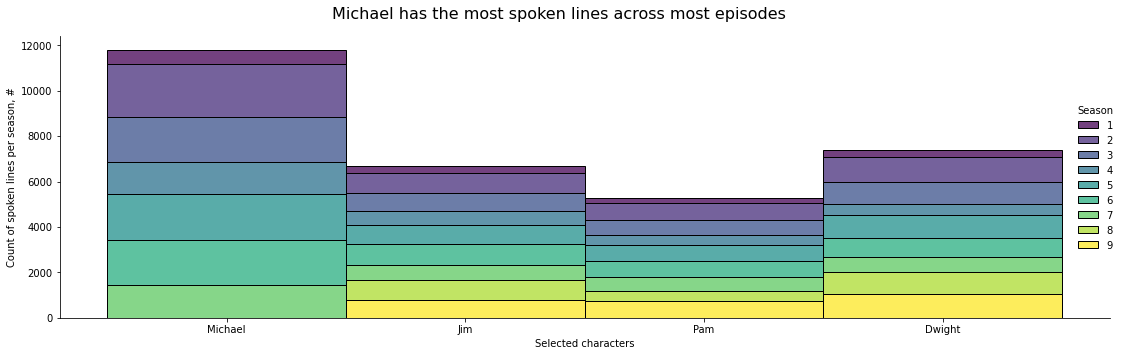

In [115]:
df_top_chars = df[df.Character.isin(['Michael', 'Jim', 'Dwight', 'Pam'])]
fig = sns.displot(df_top_chars, x='Character', hue='Season', multiple='stack', palette='viridis', height=5, aspect=3)
fig.set_xlabels('Selected characters'); fig.set_ylabels('Count of spoken lines per season, #'); 
fig.fig.suptitle('Michael has the most spoken lines across most episodes', fontsize=16);
fig.fig.tight_layout()
#fig.savefig('EDA_lines_per_char_per_episode.png')

In [6]:
# Data quality
print(f'There are {df.isna().sum().sum()} NaN values')

There are 0 NaN values


In [7]:
# Show most frequent lines
df['Line'].value_counts(ascending=False).head(10)

 Yeah.      254
 What?      213
 No.        195
 Okay.      163
 Yes.       155
 Yeah.      138
 Okay.      109
 Hey.       105
 What?       96
 No.         93
Name: Line, dtype: int64

In [8]:
# We see some weird behavior - Yeah is in there a couple times with spaces before and after and with/without punctuation.
df['Line'].value_counts(ascending=False).head(10).index

Index([' Yeah.', ' What?', ' No.', ' Okay.', ' Yes.', ' Yeah.  ', ' Okay.  ',
       ' Hey.', ' What?  ', ' No.  '],
      dtype='object')

In [9]:
# Let's do some rough cleaning
# 1) put everything to lower case
# 2) remove special characters like .,?!
# 3) remove spaces at the beginning & end of each line, and remove double spaces
# But before removing - let's count the occurrences of each of those items to remove

In [10]:
# 1) Lower case everything
df['line'] = df['Line'].str.lower()

In [11]:
special_characters = ['.', ',', '!', '\?', '  ']  
# '.'is any character except line break in regex expresion 
# need to escape the question mark since it's also an operator for if-else oneliners
for char in special_characters:
    n = df['line'].str.contains(char, regex=False).sum()
    print(f'{n:5} / {len(df)} ({n/len(df)*100:5.1f}%) of lines contain the following special character which will be removed: {char if char != "  " else "(double space)"}')

43746 / 58721 ( 74.5%) of lines contain the following special character which will be removed: .
25410 / 58721 ( 43.3%) of lines contain the following special character which will be removed: ,
 6811 / 58721 ( 11.6%) of lines contain the following special character which will be removed: !
    0 / 58721 (  0.0%) of lines contain the following special character which will be removed: \?
27329 / 58721 ( 46.5%) of lines contain the following special character which will be removed: (double space)


In [12]:
df['line'] = df['line'].map(lambda x: re.sub(r'\W+', ' ', x))

In [13]:
# Let's check again
for char in special_characters:
    n = df['line'].str.contains(char, regex=False).sum()
    print(f'{n:5} / {len(df)} ({n/len(df)*100:5.1f}%) of lines contain the following special character which will be removed: {char if char != "  " else "(double space)"}')

    0 / 58721 (  0.0%) of lines contain the following special character which will be removed: .
    0 / 58721 (  0.0%) of lines contain the following special character which will be removed: ,
    0 / 58721 (  0.0%) of lines contain the following special character which will be removed: !
    0 / 58721 (  0.0%) of lines contain the following special character which will be removed: \?
    0 / 58721 (  0.0%) of lines contain the following special character which will be removed: (double space)


In [16]:
# Looks good now. Let's check most frequent lines again :) 

In [17]:
df['line'].value_counts(ascending=False).head(10)

 yeah          625
 no            402
 what          397
 okay          383
 yes           352
 hey           241
 oh            204
 thank you     173
 ok            160
 really        139
Name: line, dtype: int64

In [18]:
# Also looks good
# Let's see how many different lines we have
print(f'{df["line"].nunique()} of {len(df)} lines (i.e., {df["line"].nunique()/len(df)*100:.1f}%) are unique')

49984 of 58721 lines (i.e., 85.1%) are unique


In [19]:
# Let's see who talks the most lines
df['Character'].value_counts(ascending=False)

Michael                    11806
Dwight                      7393
Jim                         6666
Pam                         5264
Andy                        3933
                           ...  
Dale                           1
(Pam’S Mom) Heleen             1
Dwight, Jim And Michael        1
Teddy Wallace                  1
Carol Stills                   1
Name: Character, Length: 780, dtype: int64

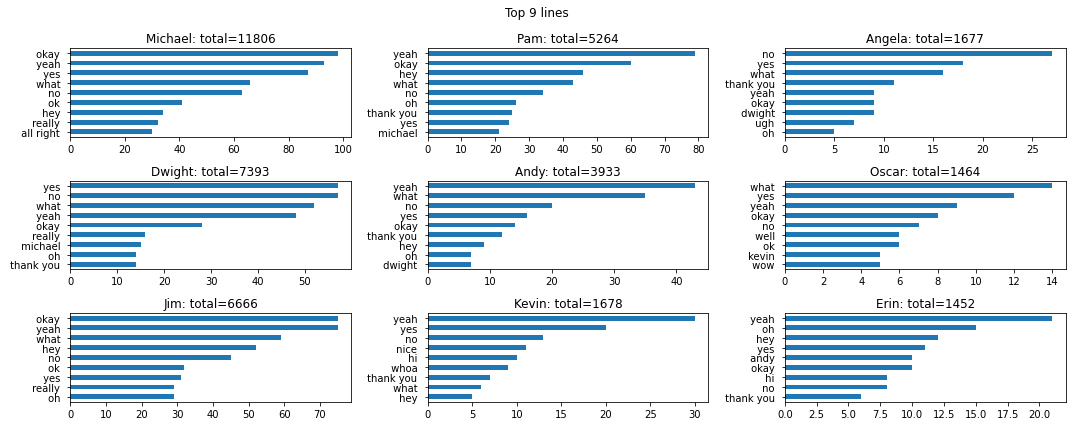

In [20]:
# For the top M characters - print their top N words
M, N=9, 9
topM_characters = df['Character'].value_counts(ascending=False).head(M).index.tolist()

# Plotting
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(15,6))
row, col = 0, 0

for i, character in enumerate(topM_characters):
    topN_lines = df[df['Character']==character]['line'].value_counts(ascending=False).head(N)

    # Plotting
    row = i%3
    col = i//3
    axis = ax[row, col]
    axis.set_title(character + f': total={len(df[df["Character"]==character])}')
    topN_lines.sort_values().plot.barh(ax=axis)

plt.suptitle(f'Top {N} lines')
plt.tight_layout()

In [21]:
# Most of these words are stopwords - let's remove them
print(sorted(stopwords.words('english')))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'shouldn', "shouldn't", 'so', 'some',

In [24]:
# define function to remove stopwords
# however, not sure we should do that: one of mike's most famous lines is "that's what she said" -> this would be reduced to: "said"
stopws = stopwords.words('english')
stopws += ['yes', 'okay', 'yeah', 'right', 'hey', 'oh']
def remove_stopwords(x):
    line = word_tokenize(x)
    line = [x for x in line if x not in stopws]
    return " ".join(line)

# example usage
print(df['line'][0])
remove_stopwords(df['line'][0])

 all right jim your quarterlies look very good how are things at the library 


'jim quarterlies look good things library'

In [25]:
# Let's remove all the stopwords
df['line_nosw'] = df['line'].apply(remove_stopwords)

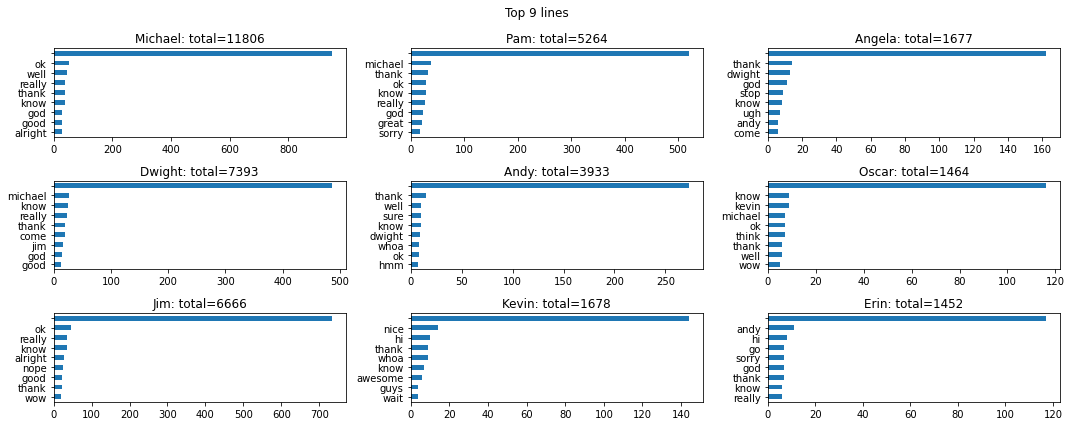

In [26]:
# For the top M characters - print their top N words
M, N=9, 9
topM_characters = df['Character'].value_counts(ascending=False).head(M).index.tolist()

# Plotting
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(15,6))
row, col = 0, 0

for i, character in enumerate(topM_characters):
    topN_lines = df[df['Character']==character]['line_nosw'].value_counts(ascending=False).head(N)

    # Plotting
    row = i%3
    col = i//3
    axis = ax[row, col]
    axis.set_title(character + f': total={len(df[df["Character"]==character])}')
    topN_lines.sort_values().plot.barh(ax=axis)

plt.suptitle(f'Top {N} lines')
plt.tight_layout()

In [27]:
# All the lines that were ONLY stopwords are now empty

# TF-IDF
$ \text{TF-IDF}_{Michael}(line_i) = \frac{count(character = michael | line=line_i)}{count(characters | line=line_i)}$

In [130]:
# Which lines are most characteristic for michael? - let's see with TF-IDF
# TF-IDF =: # of times michael uses a line / # of artists that use this line at least once

character = 'Michael'
lines = 'line_nosw'

counts = df[df['Character'] == character][lines].value_counts()
df_n = df.groupby(lines)['Character'].nunique().sort_values(ascending=False)

michael_lines = []
i = 0
for line, count in zip(counts.index, counts.values):
    if line == '':
        pass
    else:
        n_characters = df_n.loc[line]
        tf_idf = count/n_characters
        michael_lines.append((line, count, n_characters, tf_idf))
        i+=1
        if i%1000 == 0:
            print(f'line: {line}, count {count}, n_characters: {n_characters}, TF-IDF: {tf_idf:.1f}')
    

line: car michael driving god wow asleep, count 1, n_characters: 1, TF-IDF: 1.0
line: pam would stand sec sits pam chair hmm see relaxed like chair slowly sinking chair offers good support urkelnomically correct good chair think spoiled appreciate things think kids africa chairs sit big piles garbage think copiers chair slowly lowered almost michael visible desk copiers even struggles get pam chair gah even paper spoiled throw perfectly good tiramisu little tiny hair point seen light terms need nothing, count 1, n_characters: 1, TF-IDF: 1.0
line: whole year actually favorite restaurant closed, count 1, n_characters: 1, TF-IDF: 1.0
line: fantastic good good enough keep working pam international sales consultant, count 1, n_characters: 1, TF-IDF: 1.0
line: ok could someone come get please ryan, count 1, n_characters: 1, TF-IDF: 1.0
line: uh well honestly ed really wan na, count 1, n_characters: 1, TF-IDF: 1.0
line: theory need cross dot alright going office anybody needs puts dwight head

In [121]:
df_michael_tfidf = pd.DataFrame(michael_lines, columns = ['line', 'count', 'n_others', 'tfidf'])

In [122]:
df_michael_tfidf.sort_values(by='tfidf', ascending=False).head(50)

line  count  n_others  tfidf
57                              electric city scranton      6         1   6.00
85                                          ok alright      4         1   4.00
107                                    singing dundies      3         1   3.00
118                                      call scranton      3         1   3.00
71                                      da na na na na      5         2   2.50
1                                                 well     46        20   2.30
35                                           know know      9         4   2.25
294                                     know know know      2         1   2.00
238                                       stop talking      2         1   2.00
147                                              carol      2         1   2.00
265                                          done done      2         1   2.00
141                                          guys guys      2         1   2.00
139                                         gabba gool      2         1   2.00
256                                        smells good      2         1   2.00
257                                   exactly thinking      2         1   2.00
261                                          tolerance      2         1   2.00
264                                          boom boom      2         1   2.00
246                                             saving      2         1   2.00
205                                                pro      2         1   2.00
269                                          free fall      2         1   2.00
270                                    keep simulating      2         1   2.00
155                                               quiz      2         1   2.00
277                                        funny story      2         1   2.00
280                                           conflict      2         1   2.00
98                                          knock door      4         2   2.00
282                                       interrupting      2         1   2.00
283                                              ahhhh      2         1   2.00
284                                             seduce      2         1   2.00
285                                 well get warrantee      2         1   2.00
286                                     problem solved      2         1   2.00
288                                       could helped      2         1   2.00
289                                           low damn      2         1   2.00
237                                    need permission      2         1   2.00
153                                              worst      2         1   2.00
158                                      charley horse      2         1   2.00
192                                        want dwight      2         1   2.00
183                                          really ok      2         1   2.00
219                                         kevin stay      2         1   2.00
187                                         check live      2         1   2.00
189                                          case case      2         1   2.00
190                       downsizing rumors gettin old      2         1   2.00
191                       everybody could meredith old      2         1   2.00
193                                          need tell      2         1   2.00
180  know know need something kind embarrassing kno...      2         1   2.00
195                                          shut shut      2         1   2.00
214                                            explain      2         1   2.00
212                                      thing tonight      2         1   2.00
200                                            trouble      2         1   2.00
210                                           ahh come      2         1   2.00
203                                             yeeesh      2         1   2.00

In [108]:
df.groupby('line_nosw')['Character'].nunique().sort_values(ascending=False)

line_nosw
                          226
thank                      51
know                       50
ok                         44
sure                       43
                         ... 
hi must andy                1
hi must marcy               1
hi name town                1
hi nard dog lu peachem      1
zoning                      1
Name: Character, Length: 44366, dtype: int64

In [131]:
# Which lines are most characteristic for michael? - let's see with TF-IDF
# TF-IDF =: # of times michael uses a line / # of artists that use this line at least once

character = 'Michael'
lines = 'line'

counts = df[df['Character'] == character][lines].value_counts()
df_n = df.groupby(lines)['Character'].nunique().sort_values(ascending=False)

michael_lines = []
i = 0
for line, count in zip(counts.index, counts.values):
    if line == '':
        pass
    else:
        n_characters = df_n.loc[line]
        tf_idf = count/n_characters
        michael_lines.append((line, count, n_characters, tf_idf))
        i+=1
        if i%1000 == 0:
            print(f'line: {line}, count {count}, n_characters: {n_characters}, TF-IDF: {tf_idf:.1f}')

line:  there s gonna be a free room , count 1, n_characters: 1, TF-IDF: 1.0
line:  i think i do , count 1, n_characters: 2, TF-IDF: 0.5
line:  imitating her accent well i never thought i d see your face around these parts you old bastard , count 1, n_characters: 1, TF-IDF: 1.0
line:  oh yes yes yes yes just so you know he s at his funniest when you ve given him five shots , count 1, n_characters: 1, TF-IDF: 1.0
line:  okay well i am just glad this is all over , count 1, n_characters: 1, TF-IDF: 1.0
line:  i m not a master bee , count 1, n_characters: 1, TF-IDF: 1.0
line:  what s the um saying once their laughing they re that s once they re laughing that s 50 percent of them being horizontal so not that i m just not that that s my that s what i m trying to do but i think it helps kind of melts the ice breaks the ice melts breaks the ice and melts them melts their hearts , count 1, n_characters: 1, TF-IDF: 1.0
line:  oh thanks thanks it s very cool it s a three bedroom gay friendly , cou

In [169]:
df_michael_tfidf = pd.DataFrame(michael_lines, columns = ['line', 'count', 'n_others', 'tfidf'])
df_michael_tfidf.sort_values(by='count', ascending=False).head(50)

line  count  n_others     tfidf
0                          okay      98        52  1.884615
1                          yeah      93        77  1.207792
2                           yes      87        47  1.851064
3                          what      66        49  1.346939
4                            no      63        60  1.050000
5                            ok      41        37  1.108108
6                           hey      34        40  0.850000
7                        really      32        27  1.185185
8                     all right      30        29  1.034483
9                            oh      29        42  0.690476
10                         well      28        17  1.647059
11                    thank you      28        43  0.651163
12                      alright      22        19  1.157895
13                          hmm      13        18  0.722222
14                          yep      12        18  0.666667
15                        hello      12        26  0.461538
16                       mm hmm      12        23  0.521739
17                          why      11        20  0.550000
18                       i know      11        17  0.647059
19                    oh my god      10        18  0.555556
20                          wow      10        18  0.555556
21                     no no no      10        11  0.909091
22                       uh huh       9        16  0.562500
23                       dwight       9        20  0.450000
24               you re welcome       9        11  0.818182
28                       oh god       8        14  0.571429
29                   here we go       8         7  1.142857
27                         good       8        20  0.400000
26           what are you doing       8        11  0.727273
25                          pam       8        10  0.800000
30                          yup       7         9  0.777778
31                      oh okay       7         8  0.875000
32                       thanks       7        26  0.269231
33                        right       7        17  0.411765
41         that s what she said       6         4  1.500000
47                      oh yeah       6        13  0.461538
46                            i       6        10  0.600000
45                        maybe       6         4  1.500000
44                         ryan       6         6  1.000000
43                        no no       6        12  0.500000
42                           um       6        11  0.545455
39   the electric city scranton       6         1  6.000000
40                          who       6         8  0.750000
38                        mmhmm       6        13  0.461538
37                         sure       6        29  0.206897
36                           hi       6        36  0.166667
35                      mmm hmm       6        10  0.600000
34                           uh       6        10  0.600000
58                      you did       5         3  1.666667
57               da na na na na       5         2  2.500000

In [134]:
x = [x for x in df['line'].values.tolist() if 'she said' in x]

In [135]:
x

[' that s what she said pam ',
 ' does that include that s what she said ',
 ' that s what she said ',
 ' a that s what she said and b i wanted it to be impressive the biggest day of the year deserves the biggest tree of the year ',
 ' it was supposed to be for meredith cause she said she likes my drawings ',
 ' that s what she said ',
 ' uh that s what she said see haven t lost my sense of humor no no need it was a non stick grill ',
 ' she said lots of things ',
 ' that s what she said ',
 ' that s what she said jim mouths these words along with michael the thing is angela you are in here an awful lot you have complained about everybody in the office except dwight which is odd because everyone else has had run ins with dwight toby by the way what does redacted mean there is a file full of complaints in here marked redacted ',
 ' i am glad that today spurred social change that s part of my job as regional manager but you know what even if it didn t at least we put this matter to bed t

In [163]:
df_tf = df[['line', 'Character']]
df_tf['values'] = 1
pivot = df_tf.pivot_table(columns='Character', index='line', values='values', aggfunc='count').fillna(0)

/var/folders/gl/lf_ddy9561j7lbb3hpj3ks2w0000gn/T/ipykernel_1283/3758815838.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tf['values'] = 1


In [184]:
pivot = df_tf.pivot_table(columns='Character', index='line', values='values', aggfunc='count').fillna(0)

In [185]:
pivot['Michael'].sort_values(ascending=False)

line
 okay                                              98.0
 yeah                                              93.0
 yes                                               87.0
 what                                              66.0
 no                                                63.0
                                                   ... 
 it s a set of rubber gaskets for canning jars      0.0
 it s a small office                                0.0
 it s a statement of fact                           0.0
 it s a steve miller tribute band                   0.0
you want to play pool                               0.0
Name: Michael, Length: 49984, dtype: float64

In [254]:
michael_counts = pivot[pivot['Michael'] > 1]['Michael']
normalizer_michael = len(df[df.Character=='Michael']['Line'])
michael_counts /= normalizer_michael / 1e4

In [255]:
other_counts = pivot.loc[michael_counts.index, pivot.columns != 'Michael'].sum(axis=1)
normalizer_other = len(df[df.Character!='Michael']['Line'])
other_counts /= normalizer_other / 1e4

In [256]:
df_counts = pd.DataFrame([michael_counts, other_counts]).T

In [257]:
df_counts = df_counts.rename(columns={"Unnamed 0": "N_others"})

In [258]:
df_counts.head()

Michael  N_others
line                                 
                   4.235135  3.410423
 500               1.694054  0.213151
 about what        1.694054  0.852606
 absolutely        1.694054  2.770969
 after breakfast   1.694054  0.000000

(0.0, 10.0)

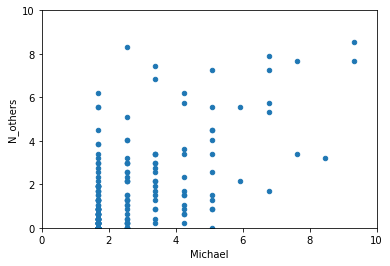

In [260]:
fig, ax = plt.subplots()
df_counts.plot.scatter(x='Michael', y='N_others', ax = ax)
ax.set_xlim([0,10]); ax.set_ylim([0,10])